In [2]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PyPDF2 import PdfReader
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Loads .env variables
%load_ext dotenv
%dotenv

## Load data

Open PDF article, divide it into overlapping chunks and create the embeddings

In [3]:
doc_reader = PdfReader('./articles/Rodolitos_recifes_peixes.pdf')
doc_reader

In [4]:
# read data from the file and put them into a variable called raw_text
raw_text = ''
for i, page in enumerate(doc_reader.pages):
    text = page.extract_text()
    if text:
        raw_text += text

len(raw_text)

43865

In [5]:
# Splitting up the text into smaller chunks for indexing
text_splitter = CharacterTextSplitter(        
    separator = "\n",
    chunk_size = 500,
    chunk_overlap  = 100, # striding over the text
    length_function = len,
)
texts = text_splitter.split_text(raw_text)

len(texts)

99

In [6]:
texts[-4]

'F.V .R., L.M.N., P .S.S., F.A.R. and F.S.M. Analyses were conceived and performed by L.A.C.J., R.L.M., P .M.C.S., \nM.L.A. and G.M.C. Geoprocessing was carried out by J.T.G. Manuscript was drafted by R.L.M., L.A.C.J. and \nM.L.A. and reviewed by all coauthors.\nCompeting interests  \nThe authors declare no competing interests.\nAdditional information\nSupplementary Information The online version contains supplementary material available at https ://doi.\norg/10.1038/s4159 8-020-80574 -w .'

In [7]:
# Create embeddings using OpenAI model
embeddings = OpenAIEmbeddings()
embed_docs = embeddings.embed_documents(texts)
len(embed_docs)

99

In [14]:
# Scales the embeddings, as PCA is highly influenced by outliers  
scaled_embed_docs = StandardScaler().fit_transform(embed_docs)

## Apply dimension reduction models

Let's use dimension reduction techniques to try to visualize the distance between the chunk embeddings

https://www.geeksforgeeks.org/difference-between-pca-vs-t-sne/

### t-SNE

In [24]:
# Create a t-SNE model to reduce the dimensions and apply it to the embeddings
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(np.array(embed_docs))

print(vis_dims.shape)
tsne

(99, 2)


TSNE(init='random', learning_rate=200, perplexity=15, random_state=42)

In [25]:
# Convert to DataFrame to facilitate plotting
tsne_df = pd.DataFrame(vis_dims)

# Converts index to column to visualize chunks distance by their ordering in the article
tsne_df = tsne_df.reset_index()
tsne_df.describe()

,index,0,1
count,99.000000,99.000000,99.000000
mean,49.000000,-7.222785,7.316013
std,28.722813,73.378952,91.564308
min,0.000000,-153.194000,-201.275696
25%,24.500000,-59.403278,-55.479443
50%,49.000000,-6.257128,16.318039
75%,73.500000,41.895384,73.018055
max,98.000000,145.016953,179.985580


### PCA

In [27]:
# Let's test now with PCA
pca = PCA(n_components=2)
vis_dims = pca.fit_transform(scaled_embed_docs)

print(vis_dims.shape)
pca

(99, 2)


PCA(n_components=2)

In [28]:
# Convert to DataFrame to facilitate plotting
pca_df = pd.DataFrame(vis_dims)

# Converts index to column to visualize chunks distance by their ordering in the article
pca_df = pca_df.reset_index()
pca_df.describe()

,index,0,1
count,99.000000,9.900000e+01,9.900000e+01
mean,49.000000,2.153160e-16,-4.485750e-18
std,28.722813,1.272568e+01,1.064675e+01
min,0.000000,-1.497816e+01,-2.088545e+01
25%,24.500000,-8.283814e+00,-7.079215e+00
50%,49.000000,-2.964571e+00,-3.689015e-01
75%,73.500000,5.630339e+00,6.895447e+00
max,98.000000,4.792184e+01,3.233799e+01


## Ploting the results

<Axes: xlabel='0', ylabel='1'>

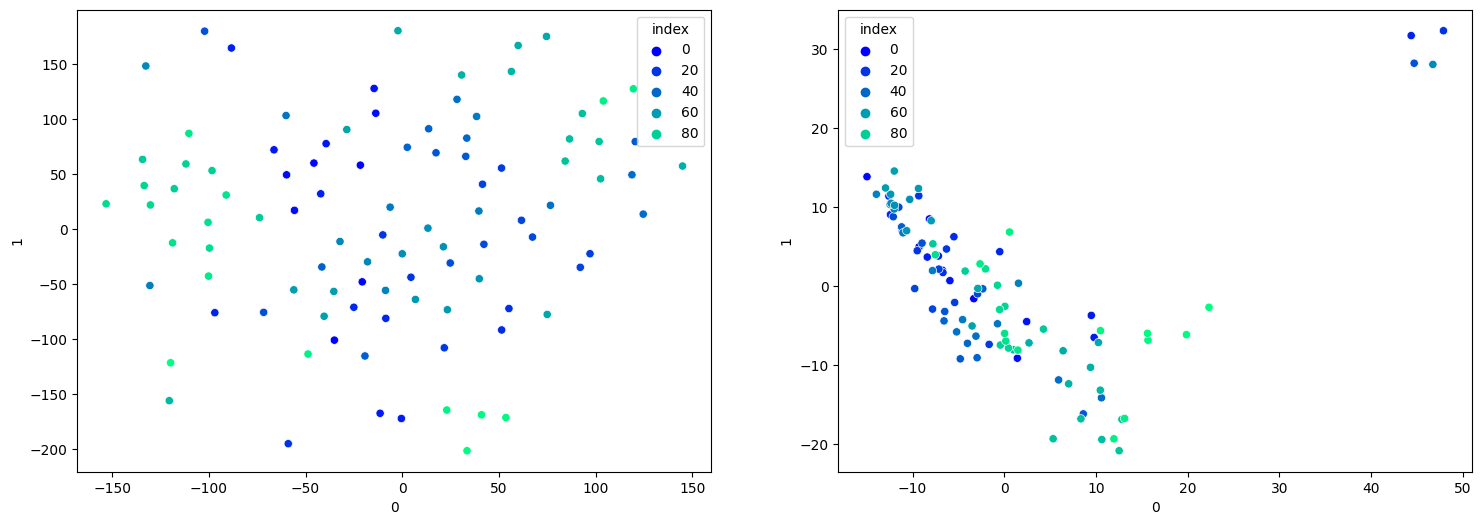

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.scatterplot(
    data=tsne_df,
    x=0,
    y=1,
    hue="index",
    palette='winter',
    ax=ax[0],
)

sns.scatterplot(
    data=pca_df,
    x=0,
    y=1,
    hue="index",
    palette='winter',
    ax=ax[1],
)